## Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import bandits as bd
from bandits import Agent, BetaAgent, Environment
sample_size = 10

# Rules:
- If $\alpha$ = $\beta$ = 1 then we have uniform distribution
- If $\alpha$ = $\beta$     then we have a symmetric distribution, where x = 1/2
- If $\alpha$ > $\beta$     then the density is right-leaning (concentrated in the neighbourhood of 1) the mean and variance will be able to be computed explicitly

# Beta-density plots
Property 1: $\alpha = \beta = 1$

In [2]:
a1 = 1
b1 = 1
case_1 = [np.random.beta(a1, b1) for x in range(0, sample_size)]

Property 2: $\alpha = \beta \neq 1$

In [3]:
r = random.random()
while r == 1:
    r = random.random()
case_2 = [np.random.beta(r, r) for x in range(0, sample_size)]

Property 3: $\alpha > \beta$

In [4]:
a3 = 1
b3 = 1
while a3 <= b3:
    a3 = random.random()
    b3 = random.random()

case_3 = [np.random.beta(a3, b3) for x in range(0, sample_size)]

Property 4: Larger values of $\alpha$ and $\beta$ produce a more peaked distribution

In [5]:
a4 = 5 # Probably have to change this
b4 = 6

case_4 = [np.random.beta(a4, b4) for x in range(0, sample_size)]

Generating plots

In [6]:
x1 = [1 for x in range(0, sample_size)]
x2 = [2 for x in range(0, sample_size)]
x3 = [3 for x in range(0, sample_size)]
x4 = [4 for x in range(0, sample_size)]

Below we demonstrate the differences between the four properties explained above of the beta-distribution.

-   Case 1, where $\alpha = \beta = 1$, demonstrates a uniform distribution
-   Case 2, where $\alpha = \beta \neq 1$, demonstrates a symmetric distribution (concentrated towards limits)
-   Case 3, where $\alpha > \beta$, demonstrates a distribution concentrated toward the upper limit of 1
-   Case 4, where $\alpha$ and $\beta$ have large values, to get more peaked values (concentrated towards $\frac{1}{2}$)

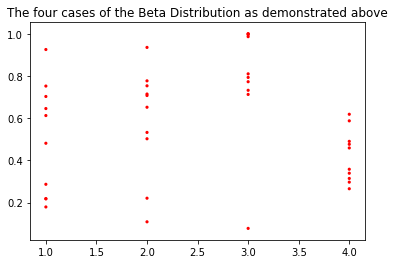

In [7]:
plt.scatter(x1+x2+x3+x4, case_1+case_2+case_3+case_4, alpha=1, c='red', edgecolors='none', s=10)
plt.title('The four cases of the Beta Distribution as demonstrated above')
plt.show()


Thompson Update Rule

In [8]:
# Get a Beta Distribution and applies the Thompson Update Rule
def thompson_update_rule(alpha: float = 1, beta: float = 1) -> (int, int):
    sample = np.random.beta(alpha, beta)              # Generate Probability
    reward = bandit_sample(sample)                    # Get reward
    return alpha+reward, beta+(1-reward)              # Amend Alpha and Beta values accordingly

Sample from a single arm, which gets a win/loss with probability $p$

In [9]:
# returns reward depending on sample passed
def bandit_sample(p: float) -> int:
    return 1 if p > random.random() else 0

# Thompson Update Rule

Computing the mean and variance of the Beta Distribution

In [10]:
def beta_mean(a: int, b: int) -> float:
    return a / (a + b)

def beta_var(a: int, b: int) -> float:
    return (a * b) / (((a + b) ** 2) * (a + b + 1))

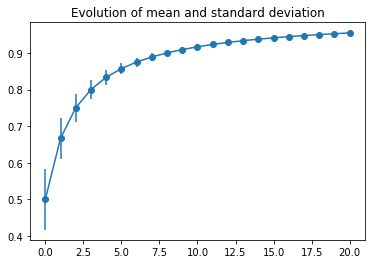

In [19]:
size = 20
tuple_values = [(1, 1)]
means = []
std_s = []

# initial state of alpha and beta... will be updated by every iteration using Thompson rule
alpha = 1
beta = 1
means.append(beta_mean(alpha, beta))
std_s.append(beta_var(alpha, beta))

for _ in range(0, size):
    alpha, beta = thompson_update_rule(alpha, beta)
    tuple_values.append((alpha, beta))
    means.append(beta_mean(alpha, beta))
    std_s.append(beta_var(alpha, beta))

plt.errorbar([x for x in range(0, len(means))], means, yerr=std_s, fmt='-o')
plt.title('Evolution of mean and standard deviation')
plt.show()

# Thompson sampling

Input: No. of arms $k$, $lim$
Output: List of thetas for each arm

In [33]:
def thompson_sampling(k: int = 2, limit: int = 10) -> list:
    # initialise alpha/beta pairs for each arm
    ab_pairs = [[1, 1] for _ in range(k)]
    thetas = [[x[0]/x[1] for x in ab_pairs]]  
    for i in range(limit):    
        samples = [np.random.beta(i[0], i[1]) for i in ab_pairs]
        si = np.argmax(samples)                                     # Choose sample with best prob to get reward
        reward = bandit_sample(samples[si])                         # Get reward
        ab_pairs[si][0] += reward                                   # Append Reward to Alpha
        ab_pairs[si][1] += (1 - reward)                             # And Beta, accordingly
        thetas += [[x[0]/x[1] for x in ab_pairs]]                   # Add the thetas to list of progress
    return thetas

$\epsilon$-greedy sampling

In [34]:
def epsilon_sampling(k: int = 2, e:float=0.1, limit: int = 10, beta_increment: float = 1) -> list:
    # initialise alpha/beta pairs for each arm
    ab_pairs = [[1, 1] for _ in range(k)]
    thetas = [[x[0]/x[1] for x in ab_pairs]]
    for i in range(limit):
        samples = [np.random.beta(i[0], i[1]) for i in ab_pairs]
        # e-greedy choice
        si = np.argmax(samples) if random.random() > e else random.choice(range(0,k))
        reward = bandit_sample(samples[si])
        # update only alpha-values for epsilon-greedy with reward
        ab_pairs[si][0] += reward
        ab_pairs[si][1] += beta_increment
        thetas += [[x[0]/x[1] for x in ab_pairs]]
    return thetas

Upper-Confidence bound sampling

In [35]:
def UCB(k: int = 2, c: int = 1, limit: int = 10, beta_increment: float = 1) -> list:
    # initialise alpha/beta pairs for each arm
    ab_pairs = [[1, 1] for _ in range(k)]
    thetas = [[x[0]/x[1] for x in ab_pairs]]
    for i in range(limit):
        samples = [np.random.beta(i[0], i[1]) for i in ab_pairs]
        # greedy choice
        si = np.argmax(samples)
        reward = bandit_sample(samples[si])
        # update only alpha-values for greedy with reward
        ab_pairs[si][0] += reward
        ab_pairs[si][1] += beta_increment
        thetas += [[x[0]/x[1] for x in ab_pairs]]
    return thetas


## Tests

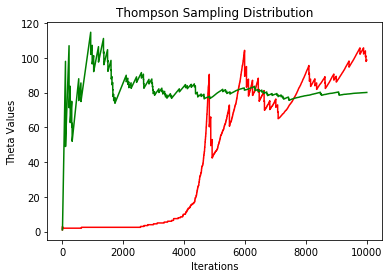

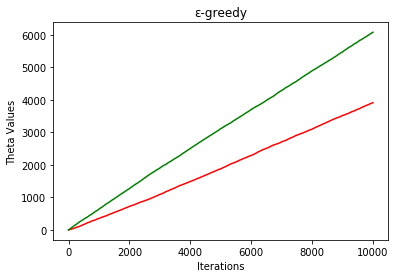

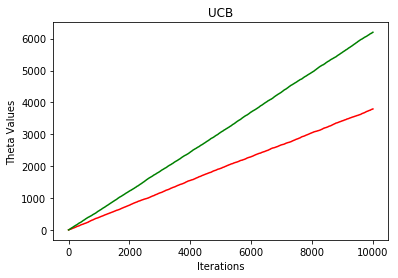

In [46]:
def run_tests(limit:int = 10000) -> None:
    k = 2
    beta = 0
    test_1 = thompson_sampling(k=k, limit=limit)
    test_2 = epsilon_sampling(k=k, e=0.1, limit=limit, beta_increment=beta)
    test_3 = UCB(k=k, c=1, limit=limit, beta_increment=beta)

    a1t1, a2t1 = [x[0] for x in test_1], [x[1] for x in test_1]
    a1t2, a2t2 = [x[0] for x in test_2], [x[1] for x in test_2]
    a1t3, a2t3 = [x[0] for x in test_3], [x[1] for x in test_3]

    x_axis = [i for i in range(limit+1)]

    plt.plot(x_axis, a1t1, 'r')
    plt.plot(x_axis, a2t1, 'g')
    plt.title('Thompson Sampling Distribution')
    plt.xlabel('Iterations')
    plt.ylabel('Theta Values')
    plt.show()

    plt.plot(x_axis, a1t2, 'r')
    plt.plot(x_axis, a2t2, 'g')
    plt.title('\u03B5-greedy')
    plt.xlabel('Iterations')
    plt.ylabel('Theta Values')
    plt.show()

    plt.plot(x_axis, a1t3, 'r')
    plt.plot(x_axis, a2t3, 'g')
    plt.title('UCB')
    plt.xlabel('Iterations')
    plt.ylabel('Theta Values')
    plt.show()

run_tests()
